# General Test

In [100]:
import json
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
import pandas as pd
import seaborn as sns

def simulate(popularity, score, rate_hate_watching=0.3, real_count=0, verbose=0, return_line=False):
    t_end = 28
    t = np.arange(0, t_end, 1)

    # Parameters
    parameters = {
        "Prob Seeing Review": 0.2,

        "Initial Number Reviews": popularity*100,
        "Initial Score": score,
        "Score Max": 5,

        "Prob Hate Watching": rate_hate_watching,

        "Review Rate": 0.00005503175002855629,

        "Prob Indifference": 0.70,

        "Popularity": popularity,

        "Initial Population": 700_000_000,

        "Prob PP to NP": 0.36,
        "Prob PP to HW": 0.9,
        "Prob NP to PP": 0.5,
        "Prob NP to HW": 0.9,
        "Prob HW to PP": 0.25,
        "Prob HW to NP": 0.25,
        "Prob HW to HW": 0.9,
        "Prob PP to PP": 0.1,
        "Prob NP to NP": 0.1
    }

    # Initial Condition
    NW0 = round(min((parameters['Popularity'] / 100), 1) * parameters['Initial Population'], 0)

    PR0 = 0         # Amount of People who have seen mostly positive reviews about the movie
    NR0 = 0         # Amount of People who have seen mostly negative reviews about the movie

    PN0 = (parameters["Initial Score"]/parameters["Score Max"]) * parameters["Initial Number Reviews"]       # Amount of Initial Positive Reviews
    NN0 = parameters["Initial Number Reviews"] - PN0                                     # Amount of Initial Negative Reviews

    prob_liking = (parameters["Initial Score"]/parameters["Score Max"])

    PP0 = 0         # Amount of People who have seriously positive reception
    NP0 = 0         # Amount of People who have seriously negative reception
    HW0 = 0         # Amount of People who have hate-watched

    I0 = 0          # Amount of People who have become indifferent

    VC = 0          #view count
    VCP = 0
    VCN = 0
    VCH = 0 

    # ODE System
    def model(t, y):
        NW, PR, NR, PP, NP, HW, I, PN, NN, VC, VCP, VCN, VCH = y
        dNWdt = -NW*parameters['Prob Seeing Review'] - parameters['Prob Indifference']*NW

        dPRdt = (PN/(PN+NN))*parameters['Prob Seeing Review']*NW - PR - parameters['Prob Indifference']*PR
        dNRdt = (NN/(PN+NN))*parameters['Prob Seeing Review']*NW - NR - parameters['Prob Indifference']*NR
        
    #     dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
    #     dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
    #     dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
        
        
        if PP + NP + HW == 0:
            dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP 
            dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP
            dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW
            
        else:
            dPPdt = prob_liking*(PR+NR) - parameters['Prob Indifference']*PP - (NP/(PP+NP+HW))*(1-prob_liking)*PP*parameters['Prob PP to NP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*PP*parameters['Prob PP to HW'] + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)
            dNPdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*NP - (PP/(PP+NP+HW))*(prob_liking)*NP*parameters['Prob NP to PP'] - (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*NP*parameters['Prob NP to HW'] + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)
            dHWdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR) - parameters['Prob Indifference']*HW - (NP/(PP+NP+HW))*(1-prob_liking)*HW*parameters['Prob HW to NP'] - (PP/(PP+NP+HW))*(prob_liking)*HW*parameters['Prob HW to PP'] + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)

        dIdt = parameters['Prob Indifference']*(NW+PR+NR+PP+NP+HW)

        # Change in Review Count
        dPNdt = parameters["Review Rate"] * PP
        dNNdt = parameters["Review Rate"] * (NP+HW)
        
        if PP + NP + HW == 0:
            dVCdt = prob_liking*(PR+NR) + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR) + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)

            dVCPdt = prob_liking*(PR+NR)
            dVCNdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR)
            dVCHdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)
        else:
            dVCdt = prob_liking*(PR+NR)\
                 + (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR)\
                 + (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob PP to PP']*PP)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob NP to NP']*NP)
            
            # Compartmentalized
            dVCPdt = prob_liking*(PR+NR)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob NP to PP']*NP+parameters['Prob HW to PP']*HW)\
                 + (PP/(PP+NP+HW))*(prob_liking)*(parameters['Prob PP to PP']*HW)
            dVCNdt = (1-prob_liking)*(1-parameters['Prob Hate Watching'])*(PR+NR)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob PP to NP']*PP+parameters['Prob HW to NP']*HW)\
                 + (NP/(PP+NP+HW))*(1-prob_liking)*(parameters['Prob NP to NP']*HW)
            dVCHdt = (1-prob_liking)*(parameters['Prob Hate Watching'])*(PR+NR)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob PP to HW']*PP+parameters['Prob NP to HW']*NP)\
                 + (HW/(PP+NP+HW))*parameters['Prob Hate Watching']*(parameters['Prob HW to HW']*HW)

        return [dNWdt, dPRdt, dNRdt, dPPdt, dNPdt, dHWdt, dIdt, dPNdt, dNNdt, dVCdt, dVCPdt, dVCNdt, dVCHdt]


    sol = solve_ivp(model, [t[0], t[-1]], [NW0, PR0, NR0, PP0, NP0, HW0, I0, PN0, NN0, VC, VCP, VCN, VCH], t_eval=t)

    if verbose > 0:
        plt.figure(figsize=(10, 5))
        # plt.plot(t, sol.y[0], label="Not Watched")

        plt.plot(t, sol.y[1], label="Positive Seen")
        plt.plot(t, sol.y[2], label="Negative Seen")

        plt.plot(t, sol.y[3], label="Positive Reception")
        plt.plot(t, sol.y[4], label="Negative Reception")
        plt.plot(t, sol.y[5], label="Hate Watchers")

        # plt.plot(t, sol.y[6], label="Indifferent", color="#6407fa")
        # plt.plot(t, sol.y[9], label="View Count")

        # plt.plot(t, sol.y[7] + sol.y[8], label="Number Reviews", color="#07fa54")

        plt.xlabel("Time (in days)")
        plt.ylabel("Population")
        text = str(parameters["Initial Score"])+"/"+str(parameters["Score Max"])
        plt.title(f"Number of Population within a specific bucket in the Hate-Watching Model, Score: {text}")
        plt.legend(bbox_to_anchor=(1, 0.5))
        plt.show()

        print("Peak Positive Seen: ", round(sol.y[1].max(), 0))
        print("Peak Day: ", t[sol.y[1].argmax()])

        print("Peak Negative Seen: ", round(sol.y[2].max(), 0))
        print("Peak Day: ", t[sol.y[2].argmax()])

        print()

        print("Peak Positive Reception: ", round(sol.y[3].max(), 0))
        print("Peak Day: ", t[sol.y[3].argmax()])

        print("Peak Negative Reception: ", round(sol.y[4].max(), 0))
        print("Peak Day: ", t[sol.y[4].argmax()])

        print("Peak HateWatched Reception: ", round(sol.y[5].max(), 0))
        print("Peak Day: ", t[sol.y[5].argmax()])

        print()

        final_vc = round(sol.y[-1].max(), 0)
        print("View Count: ", round(sol.y[-1].max(), 0), ' / ', NW0)

    if return_line:
        return sol.y
    
    return real_count-round(sol.y[-1].max(), 0)

In [96]:
final_dataset = pd.read_csv('Final_Dataset_for_study.csv')
final_dataset['difference'] = final_dataset.apply(lambda x: abs(simulate(x['popularity'], x['rating'], real_count=x['approxviews'])), axis=1)
print("MEAN ABS DIFF: ", final_dataset['difference'].mean())
final_dataset['sqr_diff'] = final_dataset['difference'] * final_dataset['difference']
print("ROOT MEAN SQ ERROR: ", (final_dataset['sqr_diff'].mean())**(1/2))
final_dataset

MEAN ABS DIFF:  19333841.57804878
ROOT MEAN SQ ERROR:  36235929.9375947


,budget,id,revenue,popularity,release_date,vote_count,release_year,profit,approxviews,review_rate,movieId,rating,difference,sqr_diff
0,30000000.0,862,373554033.0,21.946943,1995-10-30,5415.0,1995,343554033.0,85874490,0.000063,862.0,3.598930,83429973.0,6.960560e+15
1,65000000.0,8844,262797249.0,17.015539,1995-12-15,2413.0,1995,197797249.0,60413160,0.000040,8844.0,3.760163,58741555.0,3.450570e+15
2,60000000.0,949,187436818.0,17.924927,1995-12-15,1886.0,1995,127436818.0,43088923,0.000044,949.0,3.905544,41539497.0,1.725530e+15
3,58000000.0,710,352194034.0,14.686036,1995-11-16,1194.0,1995,294194034.0,80964145,0.000015,710.0,2.740334,78297645.0,6.130521e+15
4,98000000.0,1408,10017322.0,7.284477,1995-12-22,137.0,1995,-87982678.0,2302832,0.000059,1408.0,3.710181,1557568.0,2.426018e+12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1225,5300000.0,8453,22175908.0,3.003526,2006-05-26,53.0,2006,16875908.0,3385634,0.000016,8453.0,3.037500,2913035.0,8.485773e+12
1226,0.0,123229,103504.0,9.754955,2012-07-11,92.0,2012,103504.0,13003,0.007075,123229.0,2.150000,2218133.0,4.920114e+12
1227,2000000.0,159447,11666088.0,1.456046,2012-12-27,9.0,2012,9666088.0,1465588,0.000006,159447.0,3.326531,1270951.0,1.615316e+12
1228,2000000.0,75438,8000000.0,0.397106,2011-07-21,7.0,2011,6000000.0,1008827,0.000007,75438.0,2.740506,936731.0,8.774650e+11


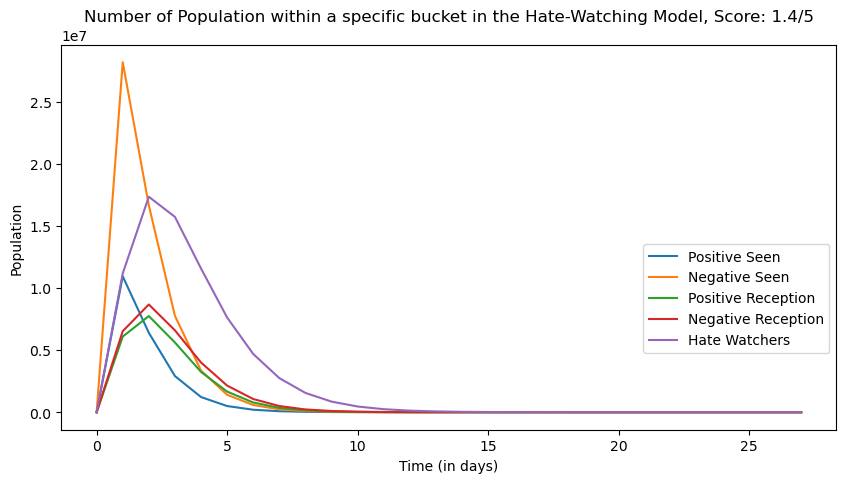

Peak Positive Seen:  10961557.0
Peak Day:  1
Peak Negative Seen:  28224655.0
Peak Day:  1

Peak Positive Reception:  7754955.0
Peak Day:  2
Peak Negative Reception:  8688537.0
Peak Day:  2
Peak HateWatched Reception:  17376979.0
Peak Day:  2

View Count:  79826549.0  /  700000000.0


-79826549.0

In [101]:
simulate(100, 1.4, 0.6, verbose=1)

# Different Scores for Views

In [65]:
lines = {}
for score in range(1, 6):
    lines[score] = simulate(100, score, return_line=True)

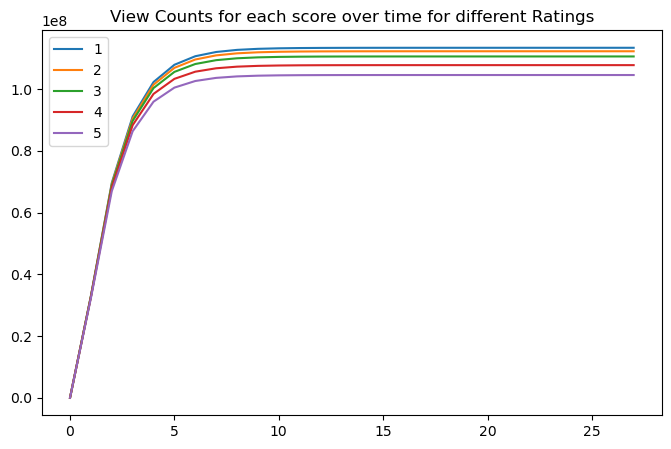

In [66]:
plt.figure(figsize=(8,5))
for score, line in lines.items():
    plt.plot(np.arange(0, 28, 1), line[9], label=score)
plt.legend()
plt.title("View Counts for each score over time for different Ratings")
plt.show()

# Different Rates of Hatewatching

In [67]:
lines = {}
for i, rate in enumerate(np.arange(0, 1, 0.1)):
    lines[i] = simulate(100, 1, rate_hate_watching=rate, return_line=True)
lines

{0: array([[7.00000000e+08, 2.84596850e+08, 1.15707599e+08, 4.70400551e+07,
         1.91272448e+07, 7.77544572e+06, 3.16088718e+06, 1.28869613e+06,
         5.25166592e+05, 2.13923243e+05, 8.71097709e+04, 3.54523118e+04,
         1.44219438e+04, 5.86667532e+03, 2.38697095e+03, 9.71459700e+02,
         3.95474951e+02, 1.61026568e+02, 6.55712843e+01, 2.67001667e+01,
         1.08703453e+01, 4.42390170e+00, 1.79969835e+00, 7.32091969e-01,
         2.97841894e-01, 1.21199067e-01, 4.93306993e-02, 2.01042897e-02],
        [0.00000000e+00, 7.83262990e+06, 4.59162500e+06, 2.10538588e+06,
         8.90832482e+05, 3.65828404e+05, 1.48507260e+05, 6.02952007e+04,
         2.44842211e+04, 9.94403591e+03, 4.04006635e+03, 1.64153834e+03,
         6.67024683e+02, 2.71149530e+02, 1.10277703e+02, 4.48708415e+01,
         1.82641817e+01, 7.43609562e+00, 3.02789854e+00, 1.23290609e+00,
         5.01940920e-01, 2.04272905e-01, 8.31003304e-02, 3.38039515e-02,
         1.37526690e-02, 5.59628931e-03, 2.2778

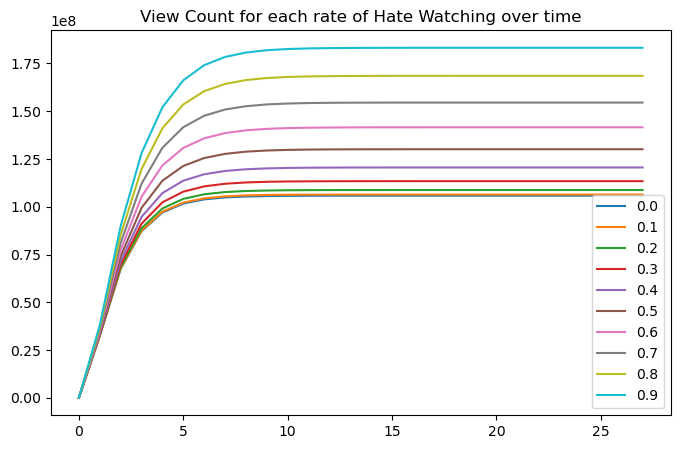

In [68]:
plt.figure(figsize=(8,5))
for score, line in lines.items():
    plt.plot(np.arange(0, 28, 1), line[9], label=score/10)
plt.legend()
plt.title("View Count for each rate of Hate Watching over time")
plt.show()

# Hate Watch vs Other Buckets for each rate

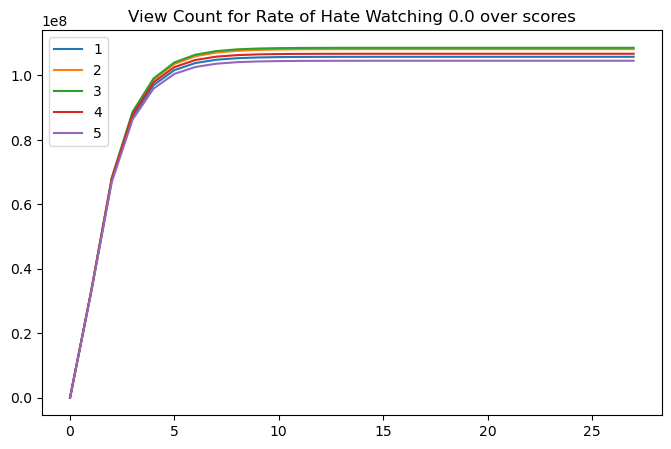

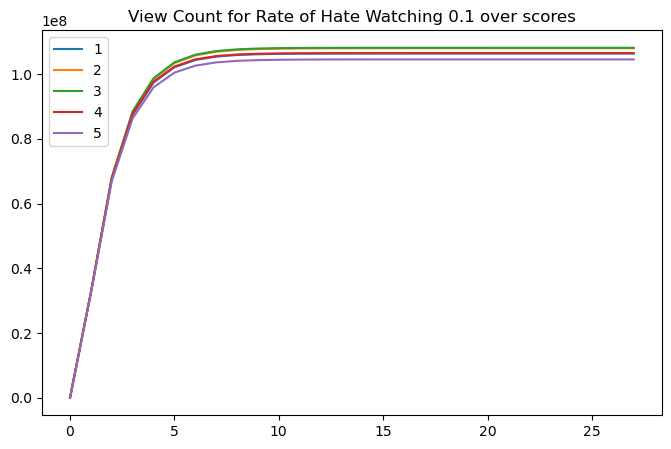

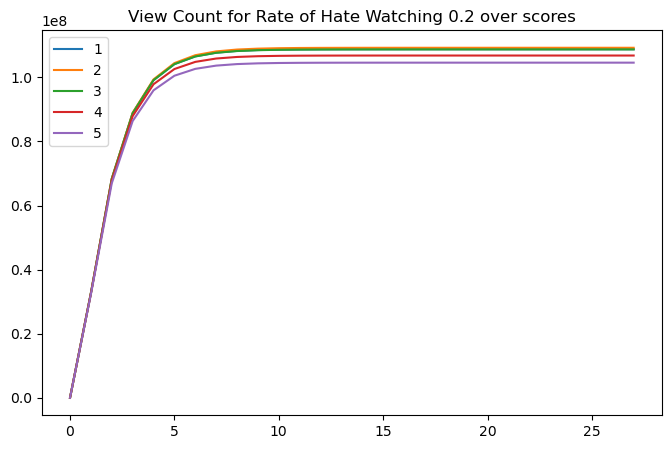

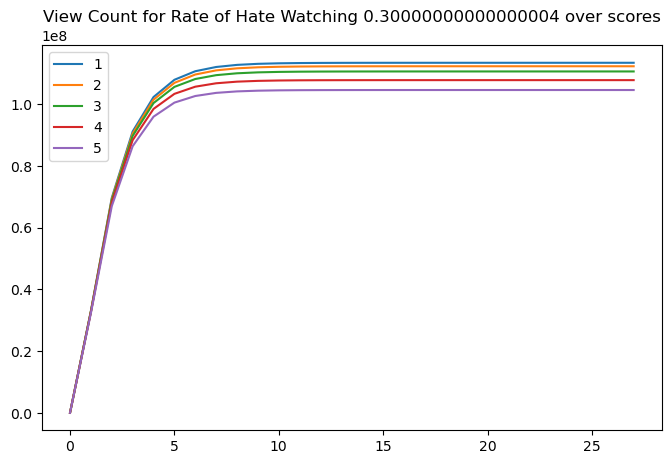

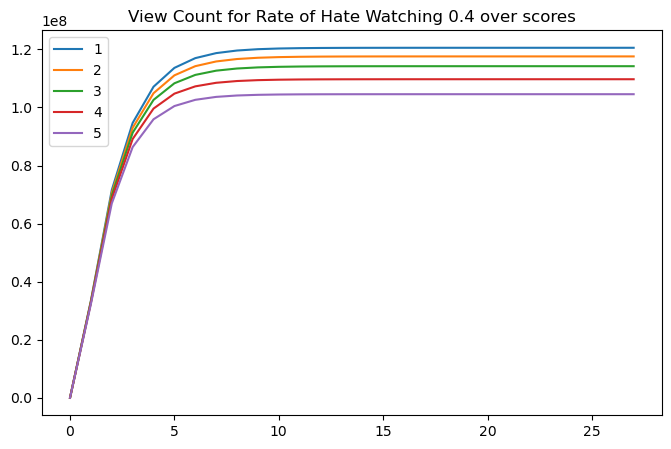

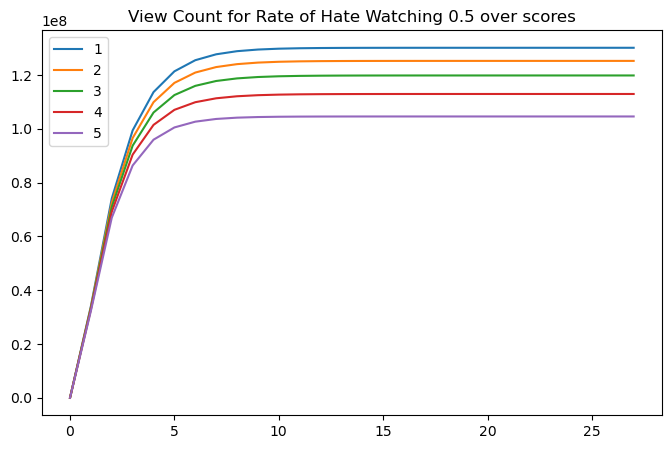

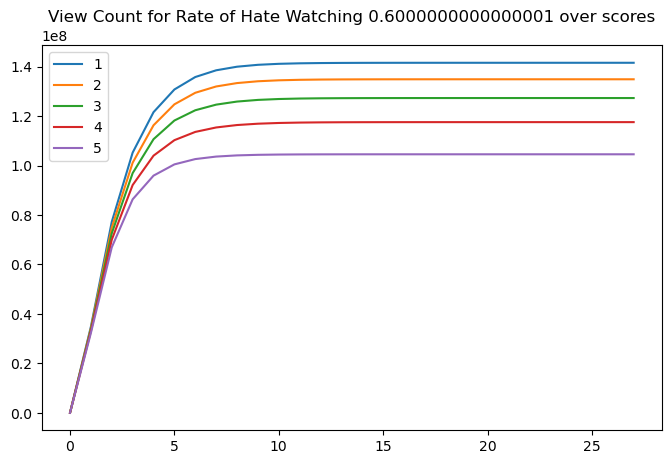

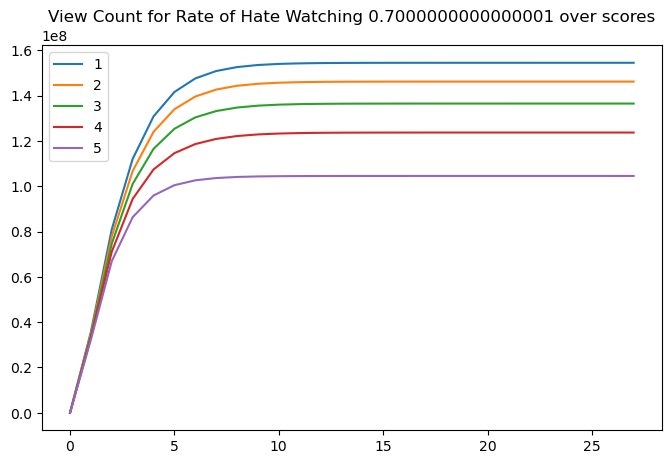

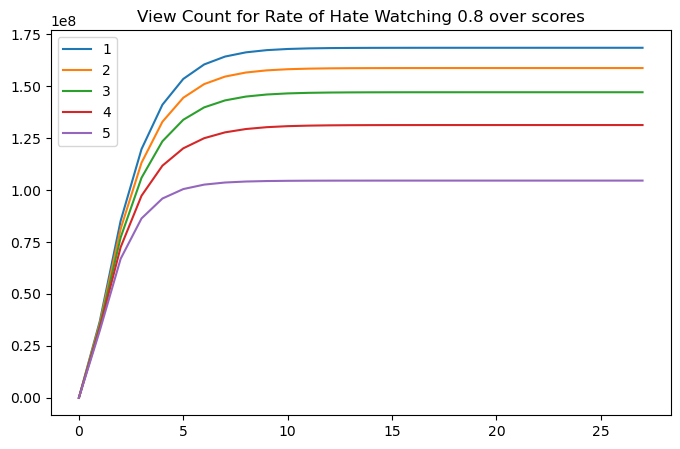

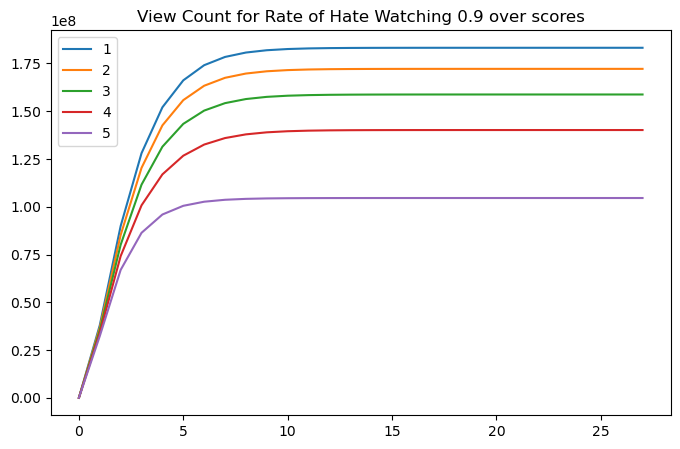

In [69]:
for rate in np.arange(0, 1, 0.1):
    lines = {}
    for score in range(1, 6):
        lines[score] = simulate(100, score, rate_hate_watching=rate, return_line=True)
    plt.figure(figsize=(8,5))
    for score, line in lines.items():
        plt.plot(np.arange(0, 28, 1), line[9], label=score)
    plt.legend()
    plt.title(f"View Count for Rate of Hate Watching {rate} over scores")
    plt.show()

# Compartmentalized 

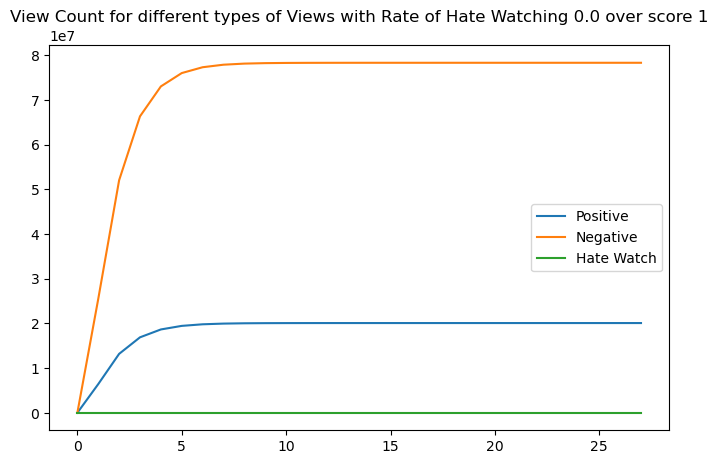

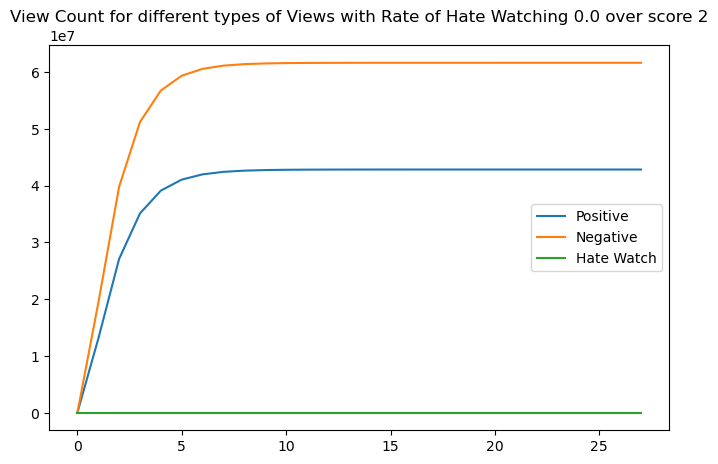

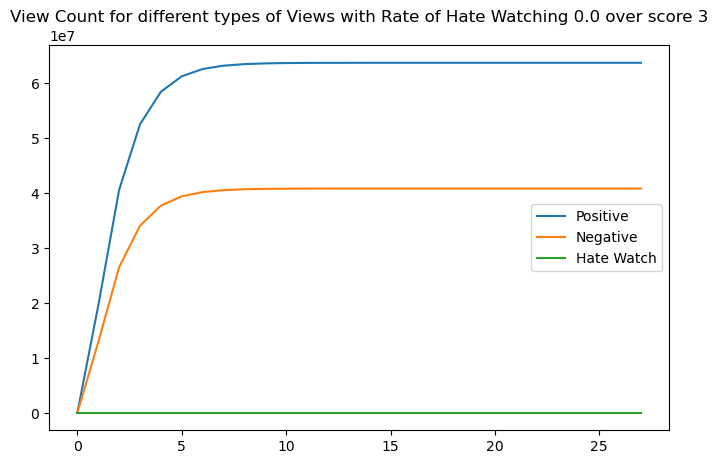

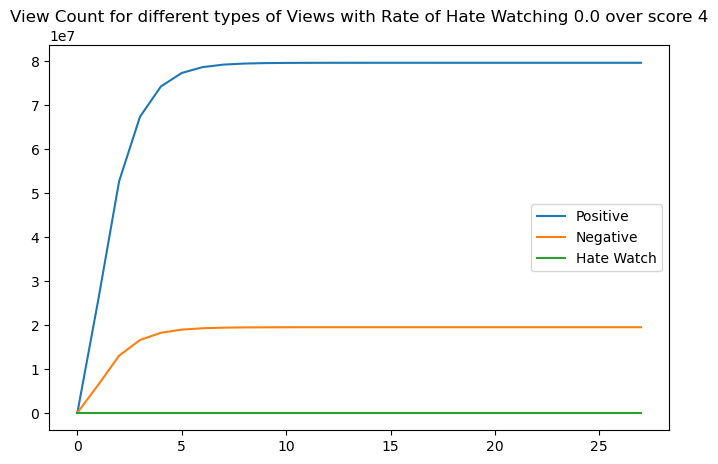

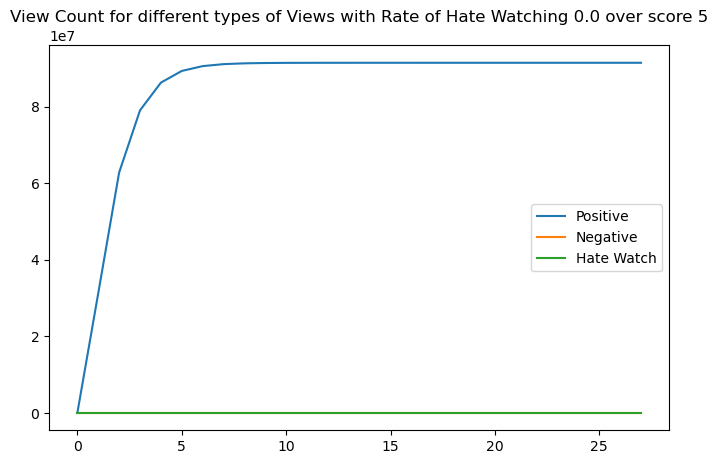

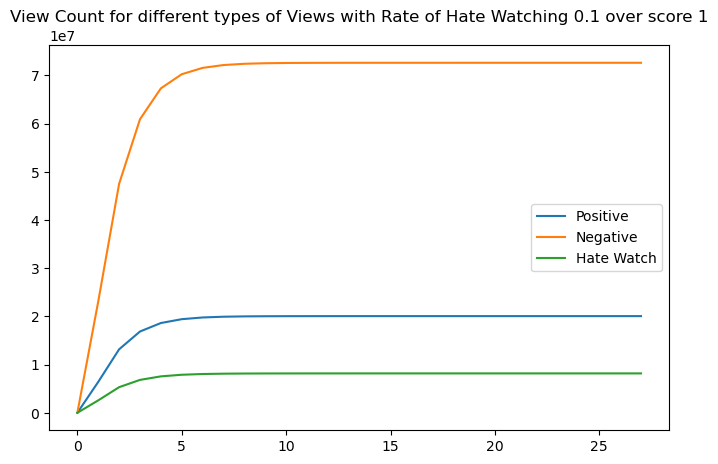

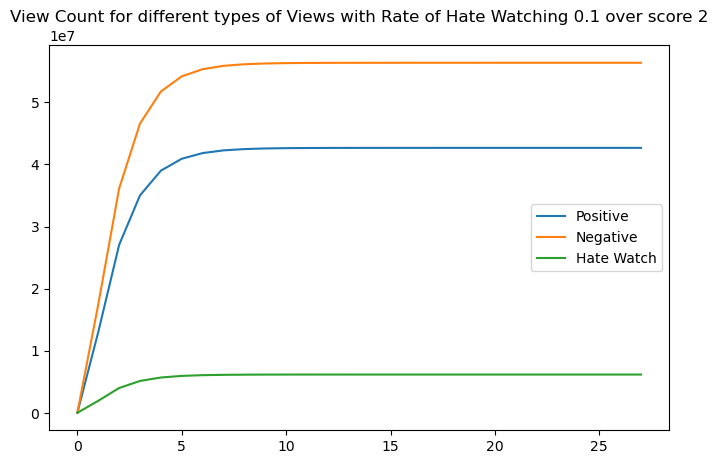

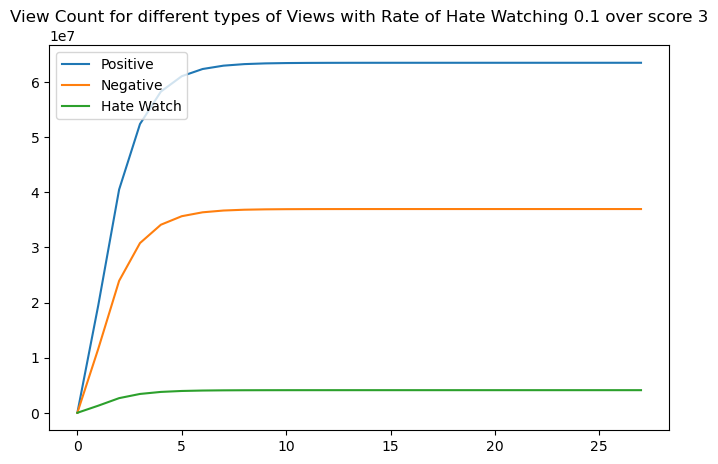

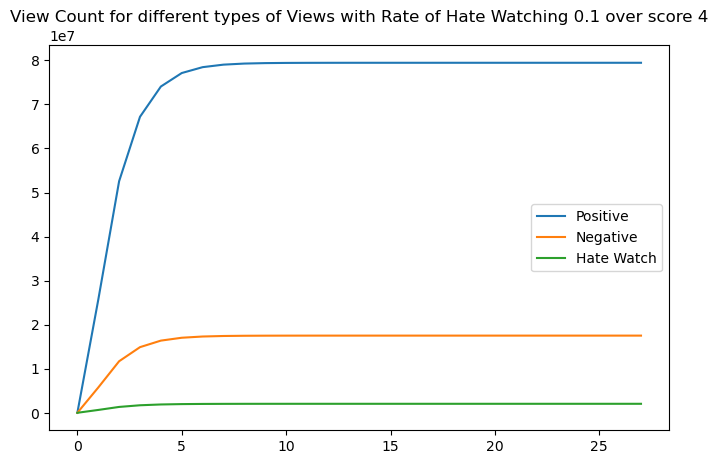

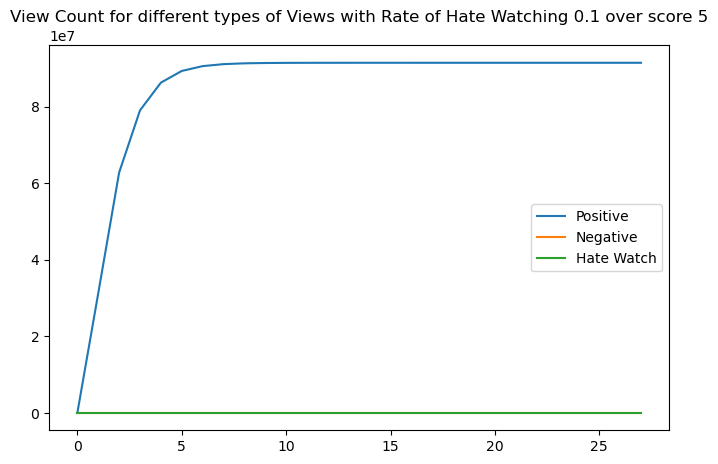

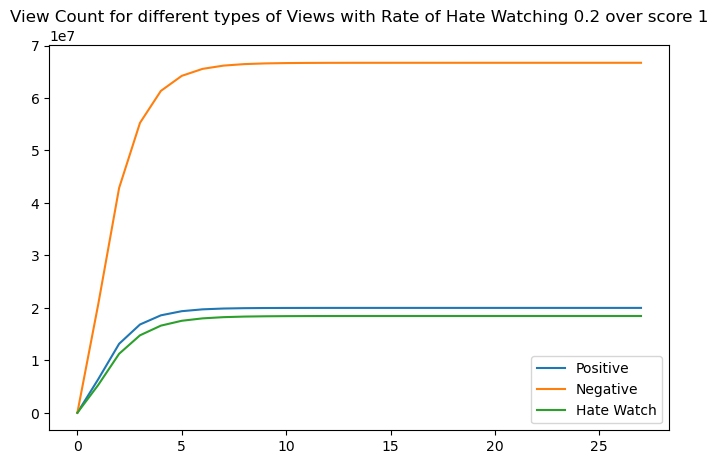

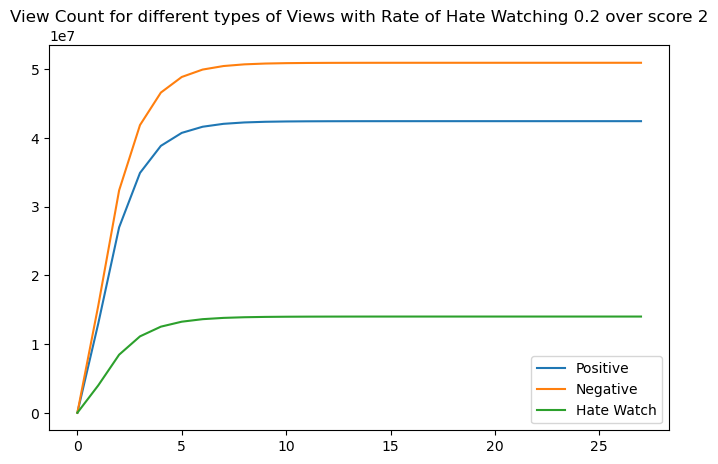

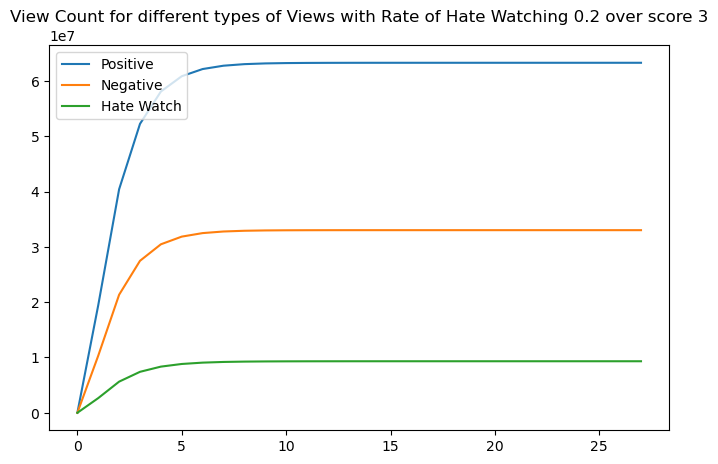

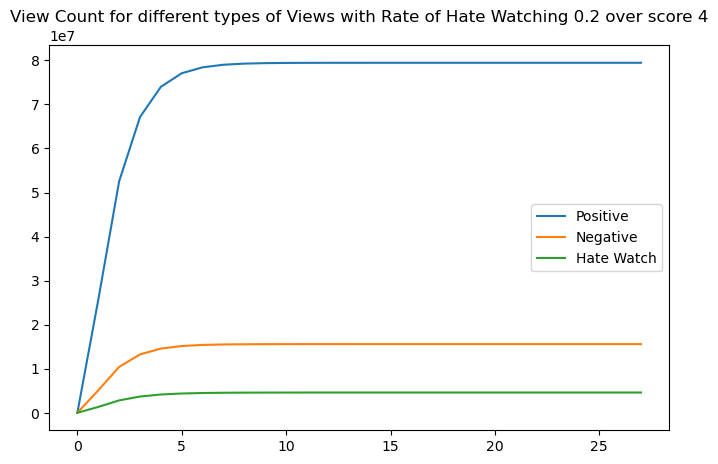

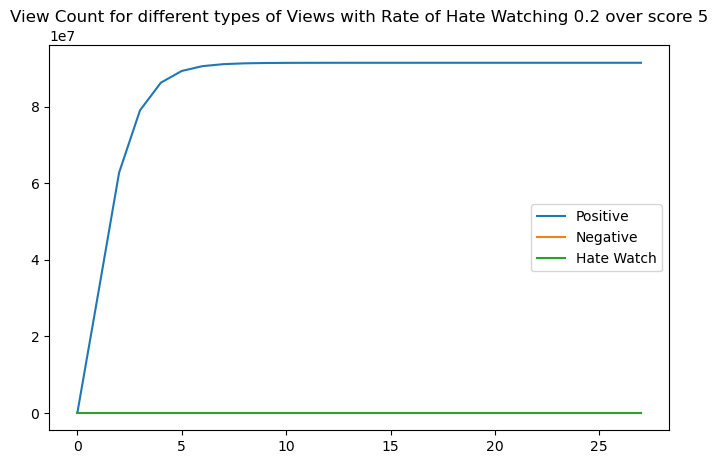

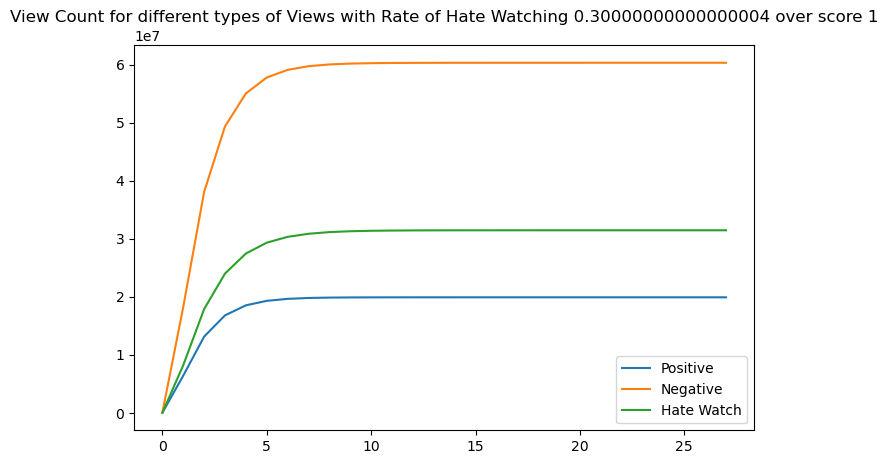

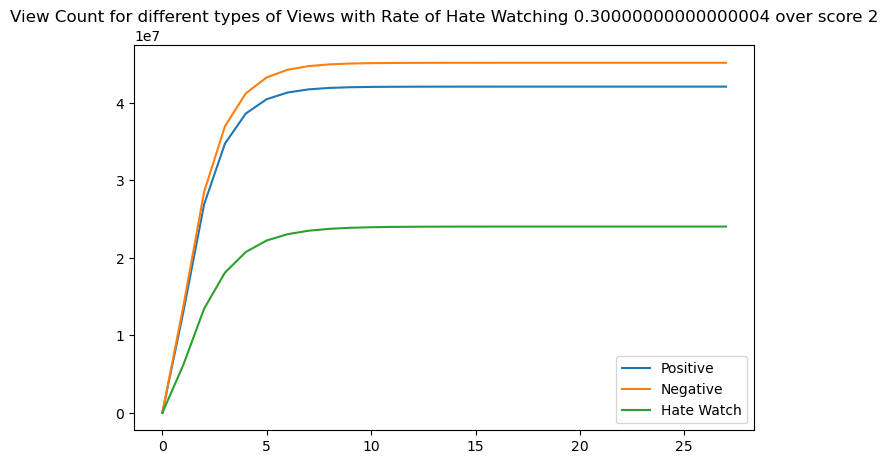

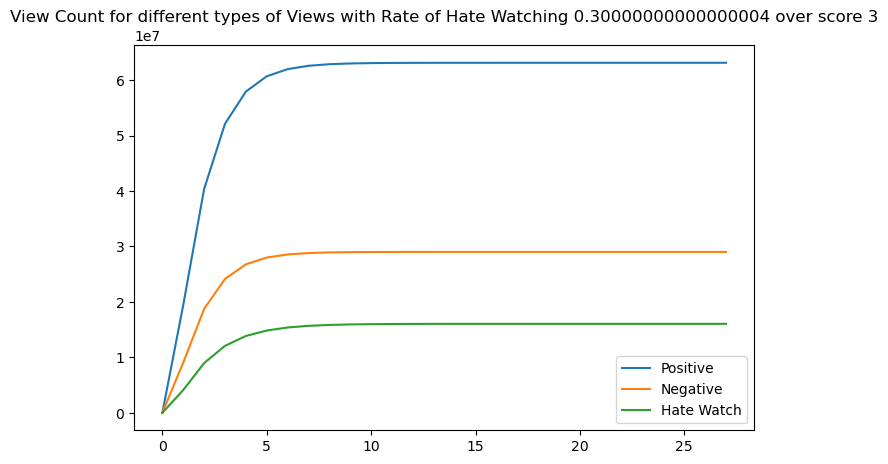

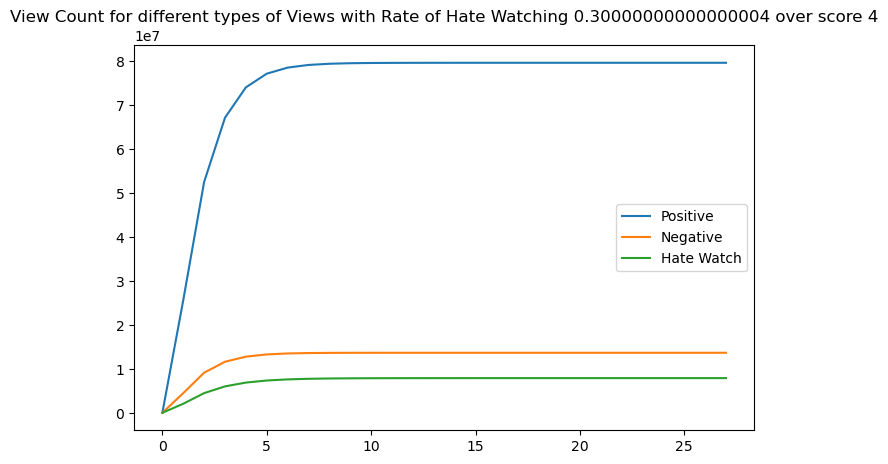

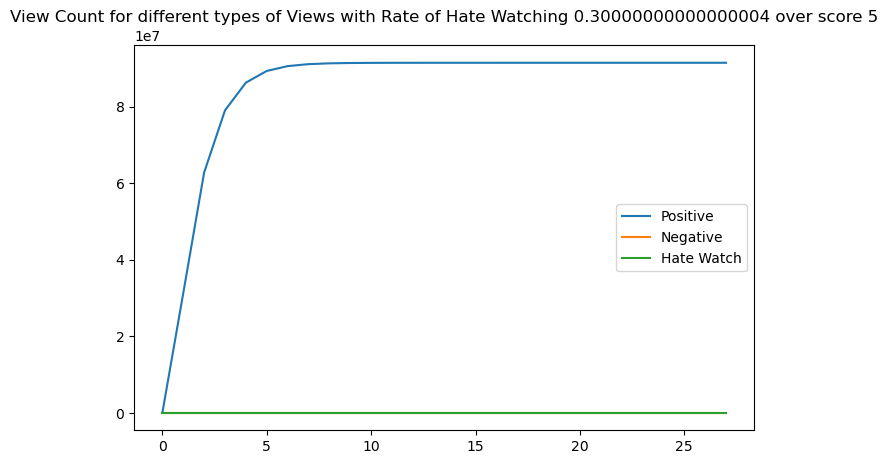

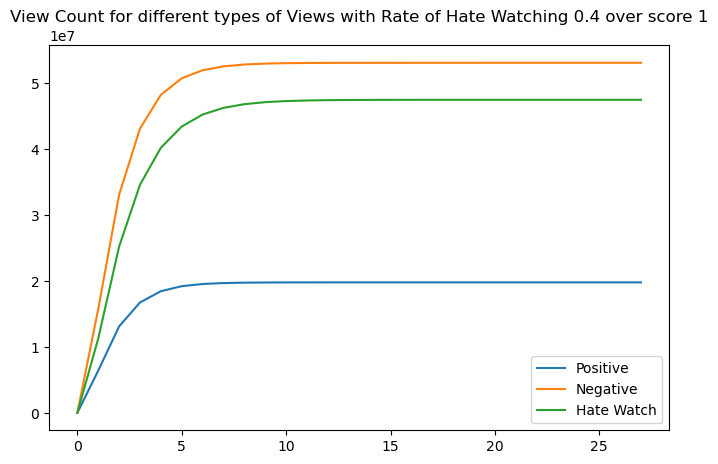

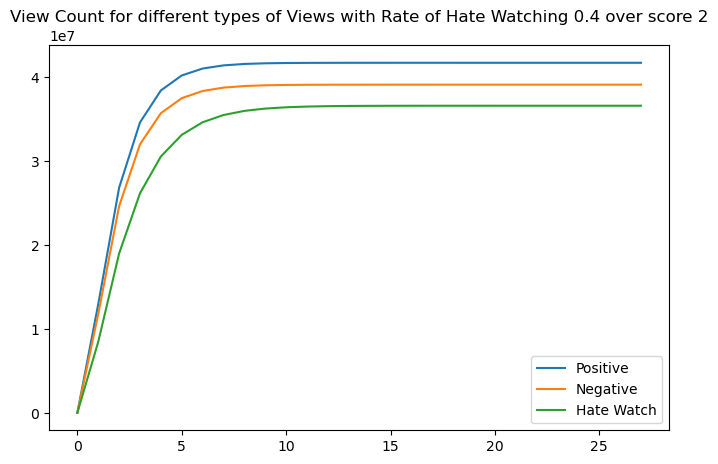

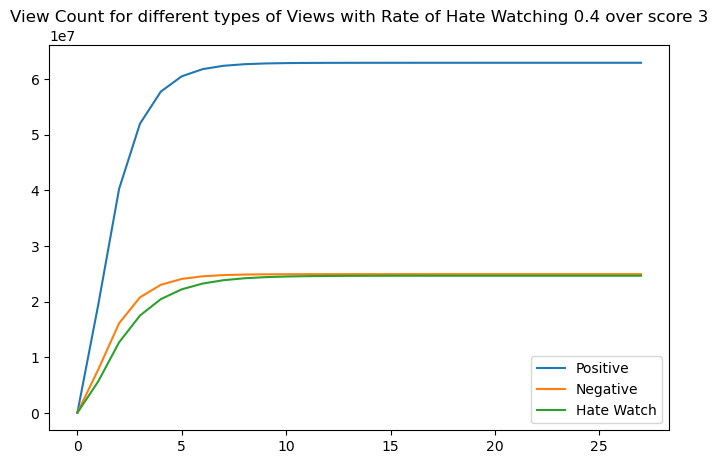

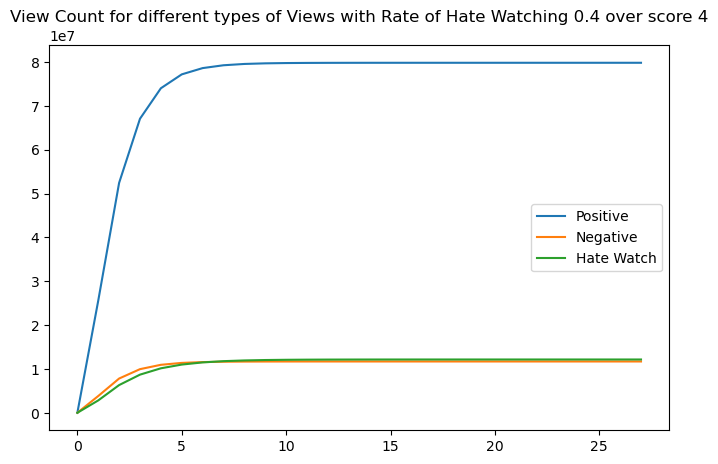

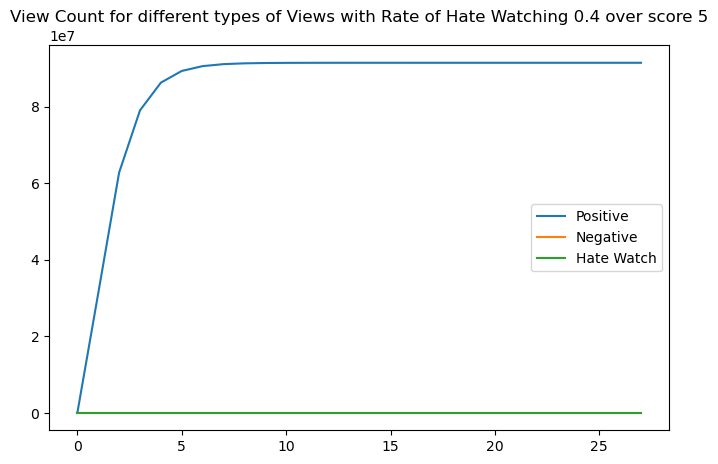

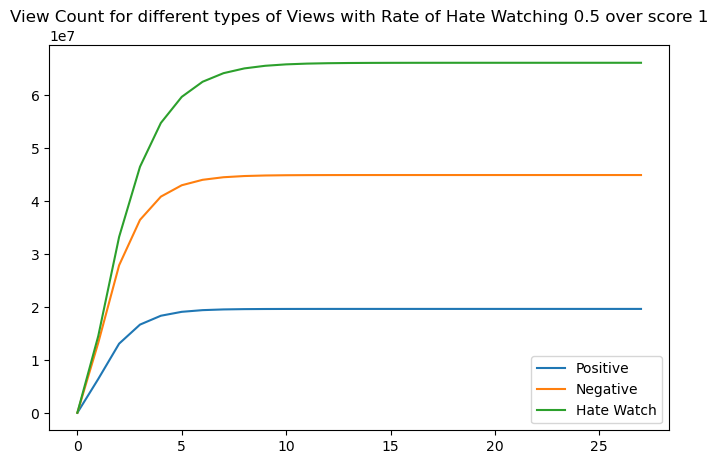

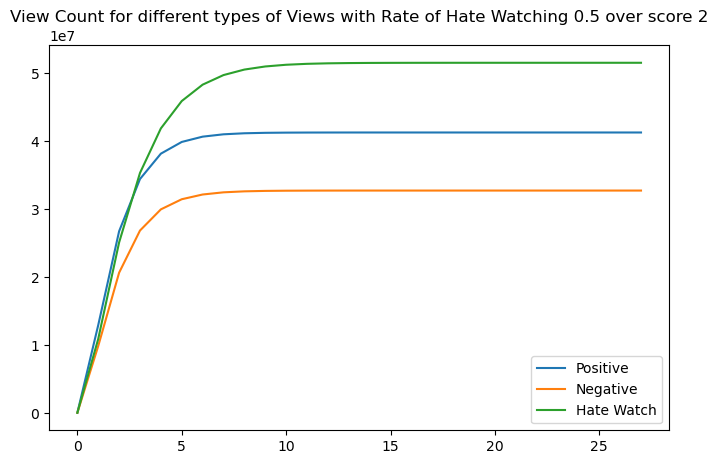

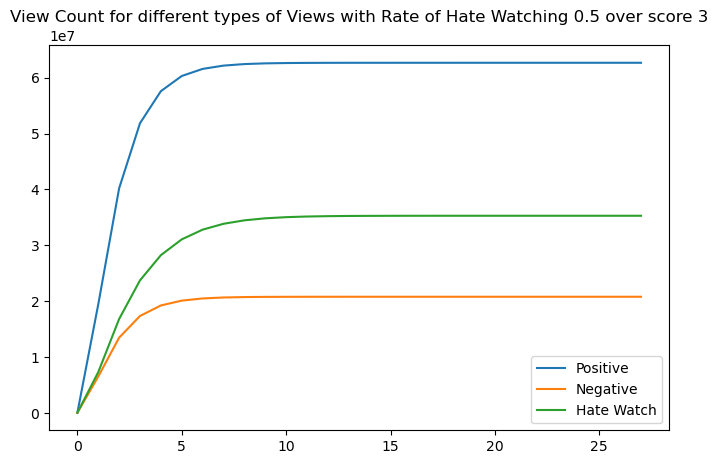

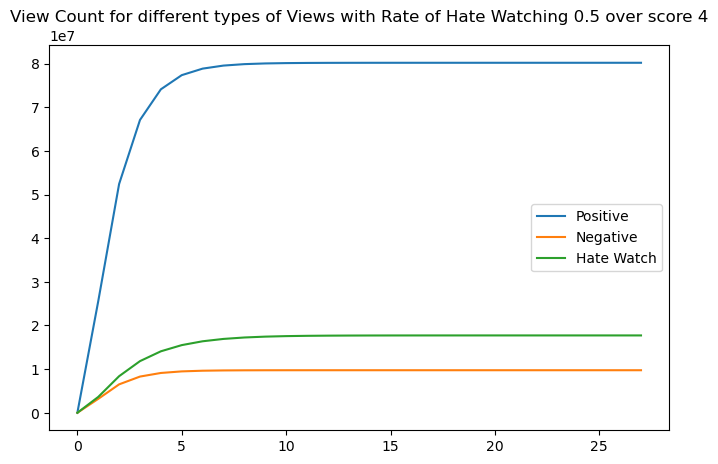

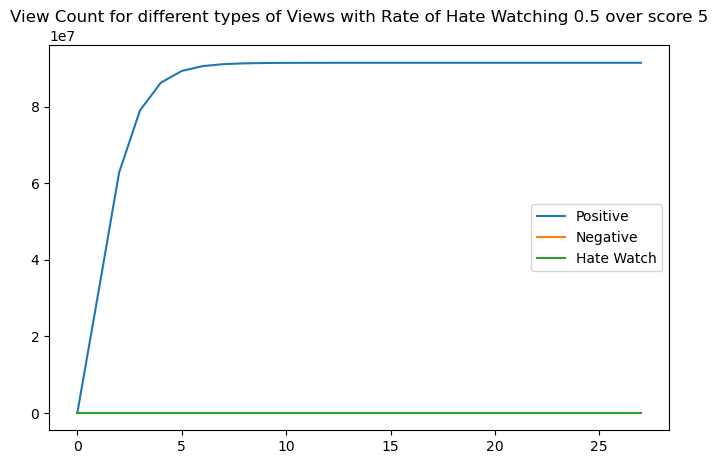

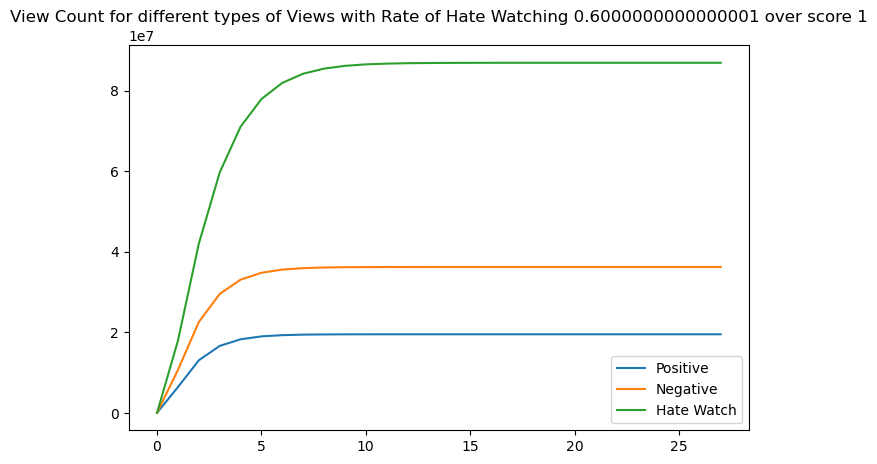

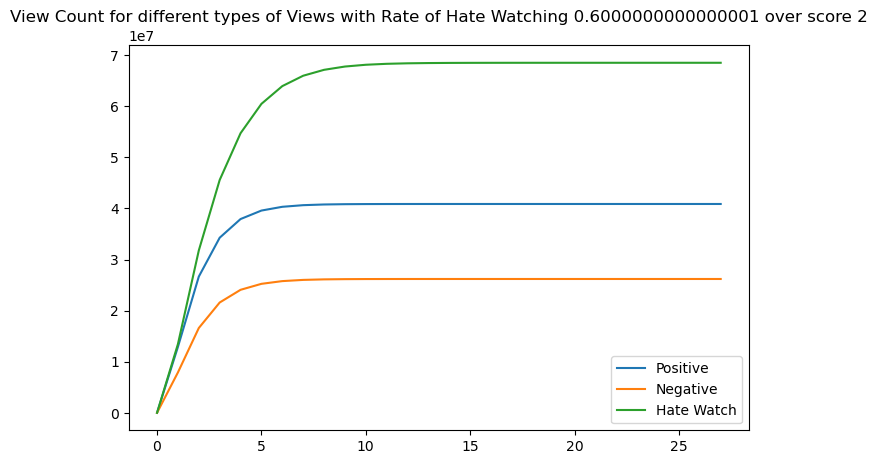

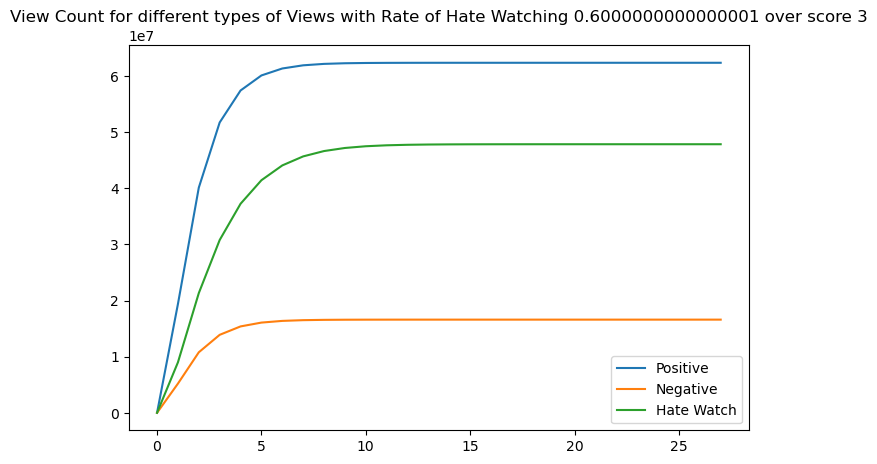

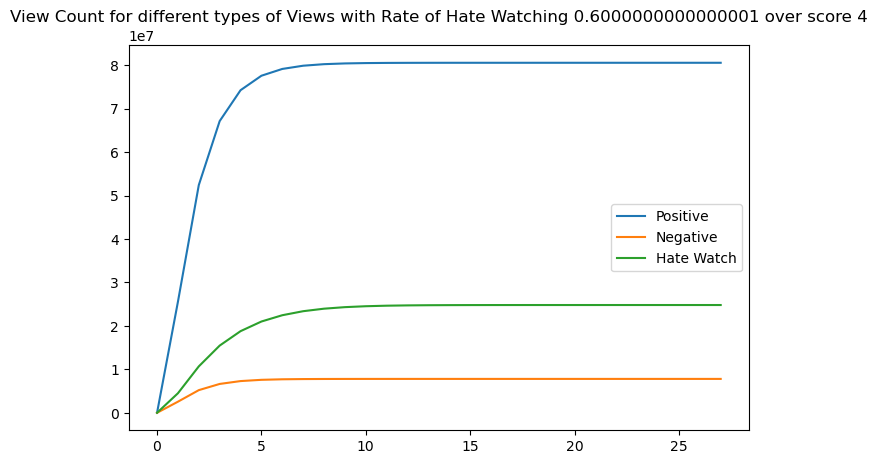

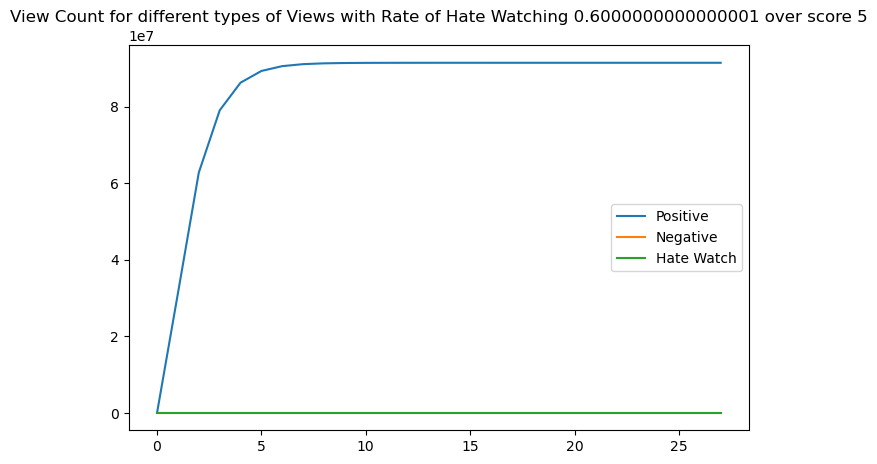

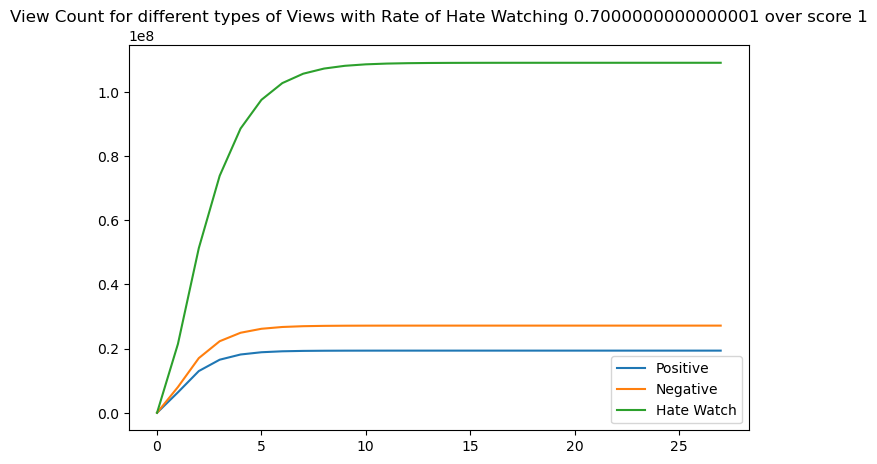

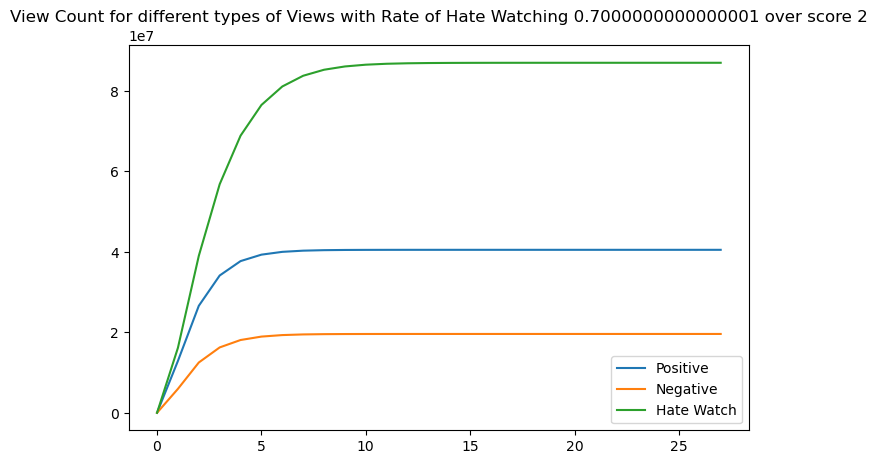

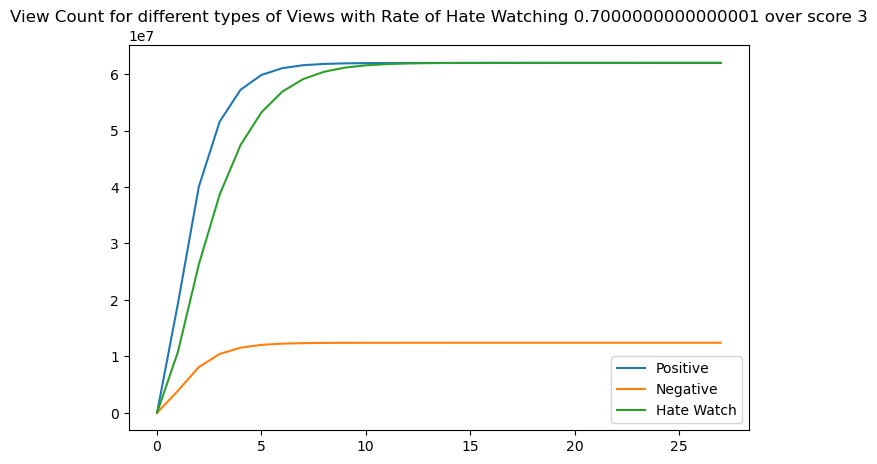

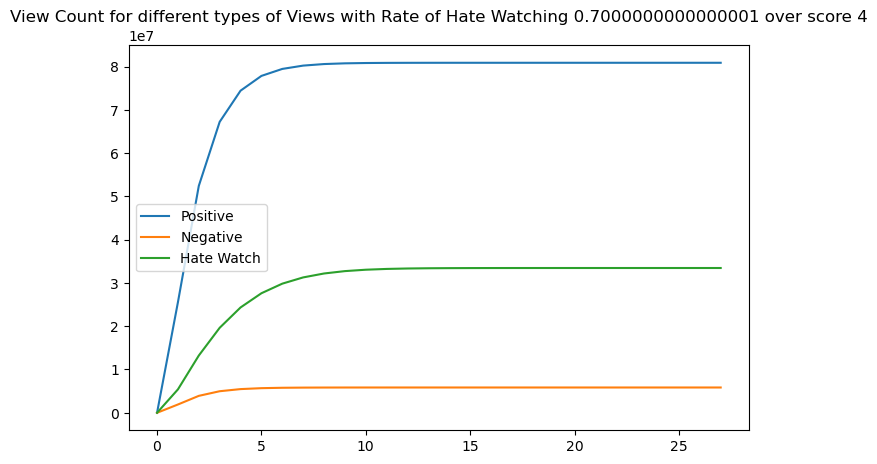

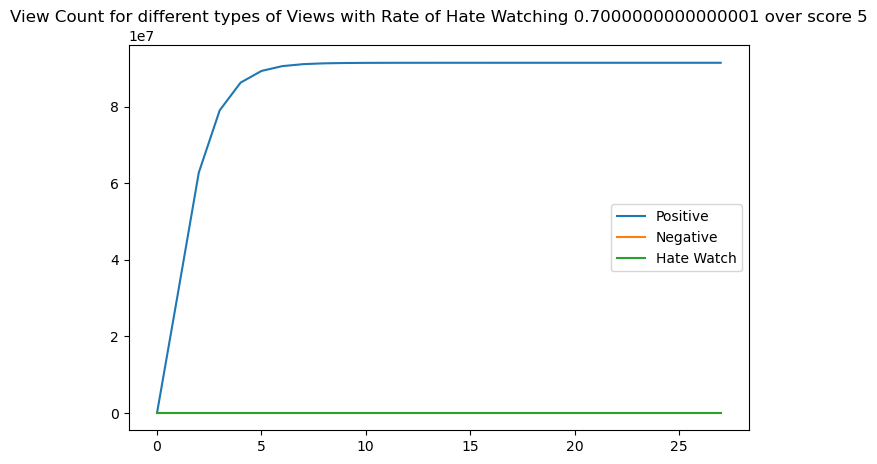

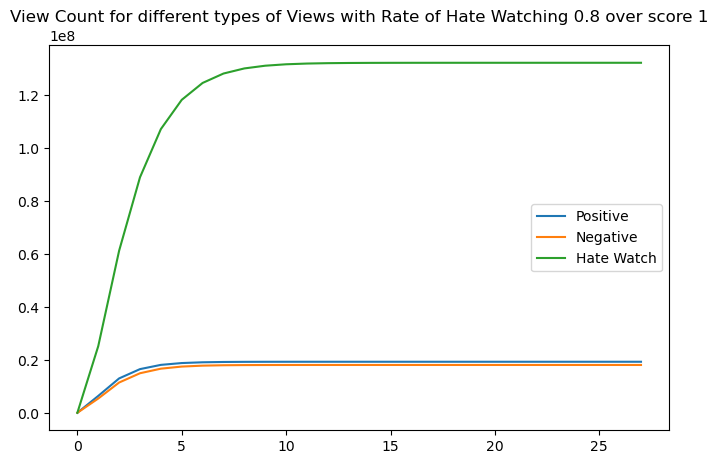

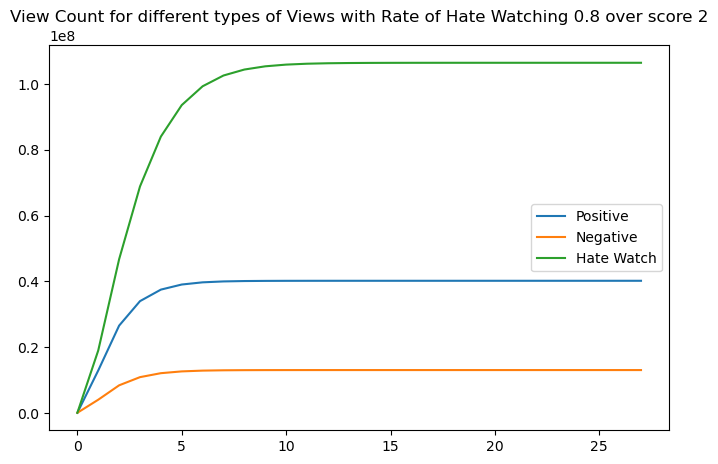

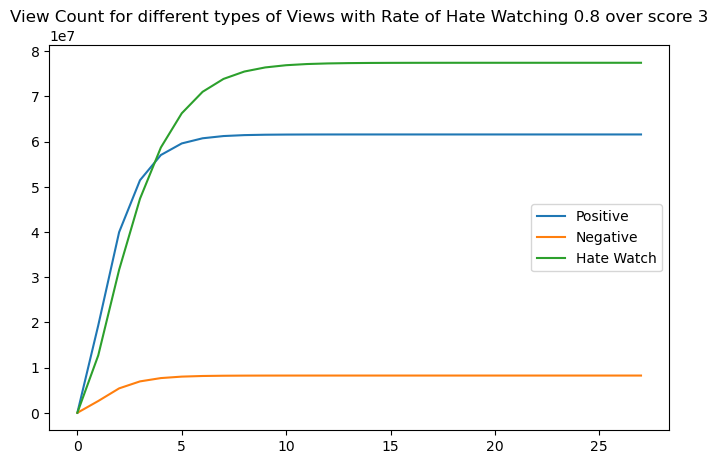

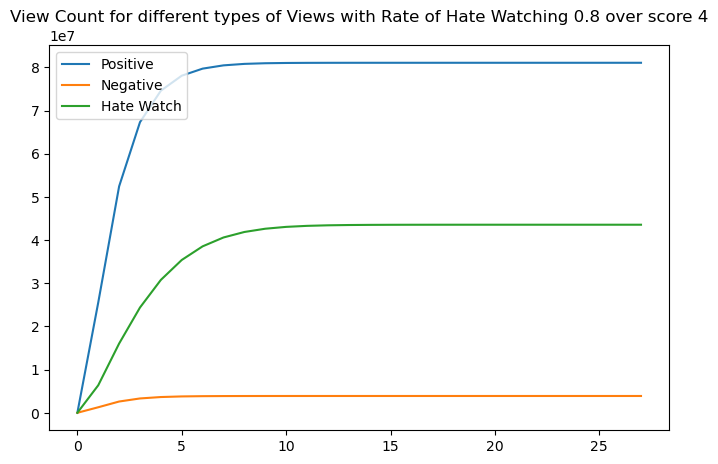

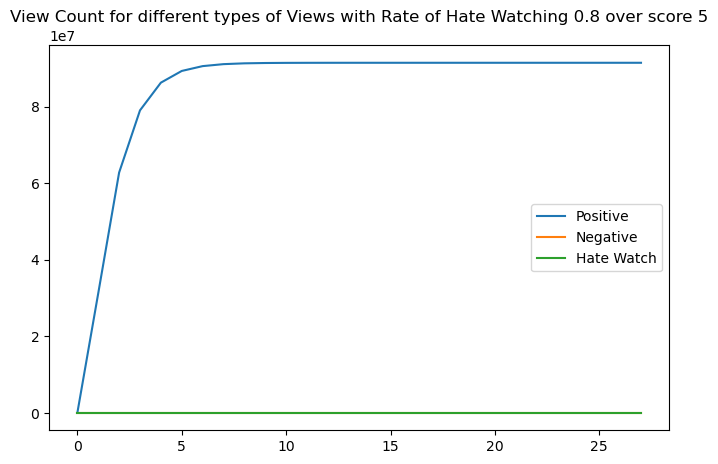

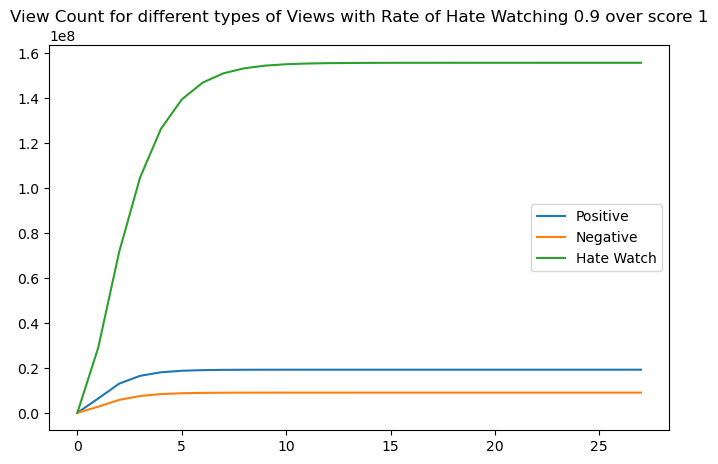

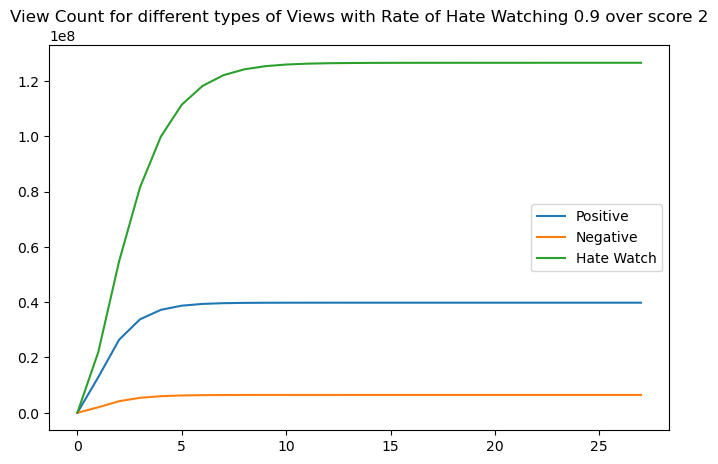

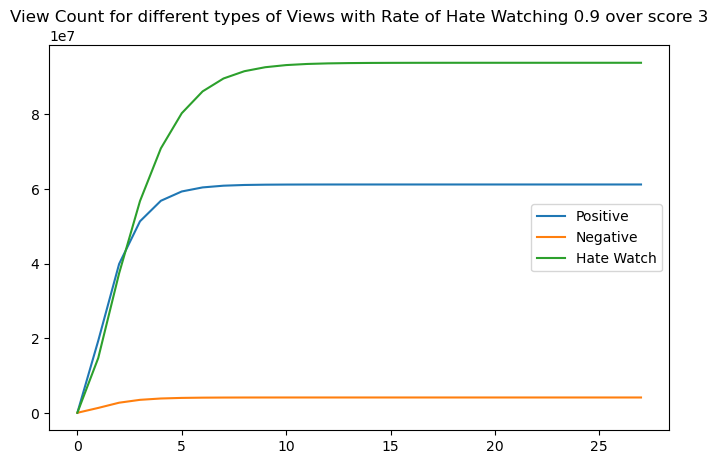

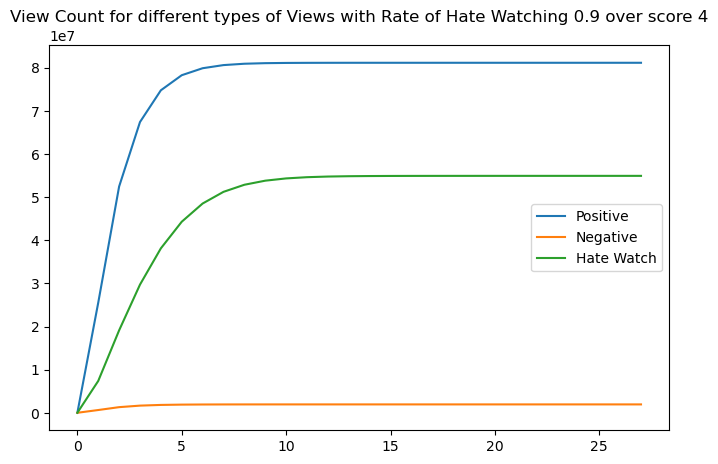

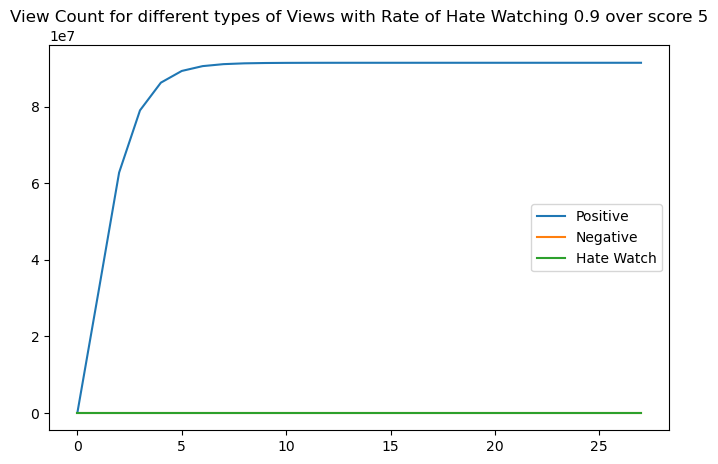

In [70]:
for rate in np.arange(0, 1, 0.1):
    lines = {}
    for score in range(1, 6):
        lines[score] = simulate(100, score, rate_hate_watching=rate, return_line=True)
    for score, line in lines.items():
        plt.figure(figsize=(8,5))
        plt.plot(np.arange(0, 28, 1), line[10], label="Positive")
        plt.plot(np.arange(0, 28, 1), line[11], label="Negative")
        plt.plot(np.arange(0, 28, 1), line[12], label="Hate Watch")
        plt.legend()
        plt.title(f"View Count for different types of Views with Rate of Hate Watching {rate} over score {score}")
        plt.show()

# Scatter for View Types

In [75]:
scatter_df = pd.DataFrame({
    'Rate_Hate_Watching': [0.0]*5 + [0.1]*5 + [0.2]*5 + [0.3]*5 + [0.4]*5 + [0.5]*5 + [0.6]*5 + [0.7]*5 + [0.8]*5 + [0.9]*5,
    'Score': [1, 2, 3, 4, 5]*10,
    'ViewType': ["Negative", "Negative", "Positive", "Positive", "Positive",
 "Negative", "Negative", "Positive", "Positive", "Positive",
 "Negative", "Negative", "Positive", "Positive", "Positive",
 "Negative", "Negative", "Positive", "Positive", "Positive",
 "Negative", "Positive", "Positive", "Positive", "Positive",
 "Hate Watch", "Hate Watch", "Positive", "Positive", "Positive",
 "Hate Watch", "Hate Watch", "Positive", "Positive", "Positive",
 "Hate Watch", "Hate Watch", "Positive", "Positive", "Positive",
 "Hate Watch", "Hate Watch", "Hate Watch", "Positive", "Positive",
 "Hate Watch", "Hate Watch", "Hate Watch", "Positive", "Positive"
] 
})
scatter_df

,Rate_Hate_Watching,Score,ViewType
0,0.0,1,Negative
1,0.0,2,Negative
2,0.0,3,Positive
3,0.0,4,Positive
4,0.0,5,Positive
5,0.1,1,Negative
6,0.1,2,Negative
7,0.1,3,Positive
8,0.1,4,Positive
9,0.1,5,Positive


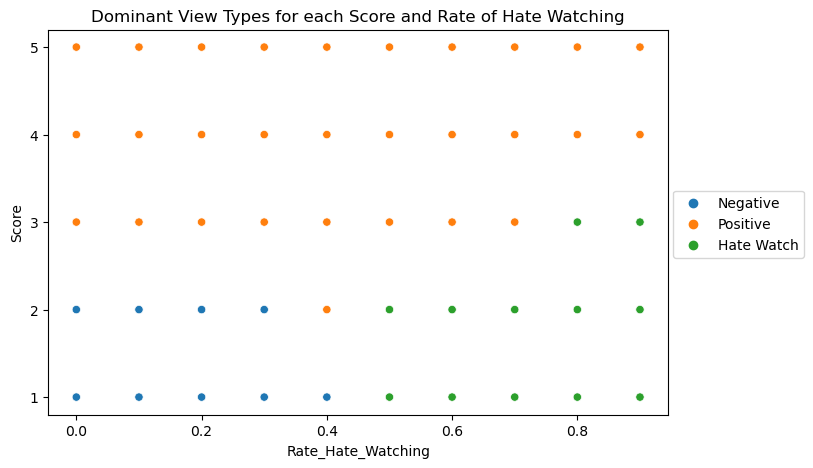

In [90]:
plt.figure(figsize=(8, 5))
sns.scatterplot(scatter_df, x='Rate_Hate_Watching', y='Score', hue='ViewType', legend=True)
plt.legend(bbox_to_anchor=(1.23, 0.6))
plt.yticks([1, 2, 3, 4, 5])
plt.title("Dominant View Types for each Score and Rate of Hate Watching")
plt.show()
